# Introduction

We will use Cyclicity Analysis to determine leader follower relations within the following categories of financial time-series: 

* Stock Daily Closing Prices
* Stock Intraday Closing Prices
* Cryptocurrency Intraday Closing Prices
* S&P 500 Index Daily Closing Prices

$\textbf{Note}:$ In order for all code cells to run without errors, please run the code cell below, which imports all the needed libraries. If a certain library fails to import, run the magic command 
<code>!pip3 install \<insert library name here\></code> in a new Code cell.

In [1]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/StockMarketAnalysis')

from CyclicityAnalysis import *
from FetchPrices import *
from joblib import Parallel, delayed
import os
import requests
import json
import scipy as sc
import scipy.signal
from bs4 import BeautifulSoup
from LeaderFollowerFrequencyAnalysis import *

# Fetching S&P 500 Sector Companies

The $500$ most influential companies in the Stock Market are divided into $11$ different categories, known as $\textbf{S&P 500 sectors (indices)}.$ These sectors are listed below.

* Comsumer Discretionary: https://www.tradingview.com/symbols/SP-S5COND/components/
* Financials: https://www.tradingview.com/symbols/SP-SPF/components/
* Energy: https://www.tradingview.com/symbols/SP-SPN/components/
* Information Technology: https://www.tradingview.com/symbols/SP-S5INFT/components/
* Health Care: https://www.tradingview.com/symbols/SP-S5HLTH/components/
* Materials: https://www.tradingview.com/symbols/SP-S5MATR/components/
* Consumer Staples: https://www.tradingview.com/symbols/SP-S5CONS/components/
* Communication Services: https://www.tradingview.com/symbols/SP-S5TELS/components/
* Real Estate: https://www.tradingview.com/symbols/SP-S5REAS/components/
* Industrials: https://www.tradingview.com/symbols/SP-S5INDU/components/
* Utilities: https://www.tradingview.com/symbols/SP-S5UTIL/components/

In the code cell below, we obtain the companies for a given S&P 500 sector. The companies are represented by their Stock Market abbreviations.

In [2]:
SP_500_sector_trading_view_abbrevs_dict= {'Consumer Discretionary': 'S5COND',
                                          'Financials' : 'SPF', 
                                          'Energy': 'SPN',
                                          'Information Technology': 'S5INFT',
                                          'Health Care': 'S5HLTH', 
                                          'Materials': 'S5MATR',
                                          'Consumer Staples': 'S5CONS',
                                          'Communication Services': 'S5TELS',
                                          'Real Estate': 'S5REAS',
                                          'Industrials': 'S5INDU', 
                                          'Utilities': 'S5UTIL'}



def get_SP_500_sector_stock_abbrevs(sector_name):
    
    try:
        os.makedirs('S&P 500 Companies')
    except:
        pass
    
    file_path="S&P 500 Companies/{}.csv".format(sector_name)
    
    SP_500_sector_stock_abbrevs_df = None
    if os.path.exists(file_path):
        SP_500_sector_stock_abbrevs_df=pd.read_csv(file_path,index_col=0)

    
    else:
        SP_500_sector_trading_view_abbrev = SP_500_sector_trading_view_abbrevs_dict[sector_name]
        URL="https://www.tradingview.com/symbols/SP-{}/components/".format(SP_500_sector_trading_view_abbrev)
        print(URL)
        content=requests.get(URL).content
        soup=BeautifulSoup(content)
        SP_500_sector_stock_abbrevs = [a.find('a')['href'].split("-")[-1].replace("/","") 
                                       for a in soup.find_all('td') 
                                       if a.find('a') != None and 'symbols' in a.find('a')['href']]
        
        SP_500_sector_stock_abbrevs_df=pd.DataFrame(SP_500_sector_stock_abbrevs,
                                                    columns=['{} Stock Abbreviations'.format(sector_name)])
        SP_500_sector_stock_abbrevs_df.to_csv(file_path)
        return SP_500_sector_stock_abbrevs
    
    SP_500_sector_stock_abbrevs= list(SP_500_sector_stock_abbrevs_df['{} Stock Abbreviations'.format(sector_name)].unique())
    return SP_500_sector_stock_abbrevs


SP_500_sector_names=list(SP_500_sector_trading_view_abbrevs_dict.keys())
print(get_SP_500_sector_stock_abbrevs("Financials"))

['AFL', 'AIG', 'AIZ', 'AJG', 'ALL', 'AMP', 'AON', 'AXP', 'BAC', 'BEN', 'BK', 'BLK', 'BRK.B', 'BRO', 'C', 'CB', 'CBOE', 'CFG', 'CINF', 'CMA', 'CME', 'COF', 'DFS', 'FITB', 'FRC', 'GL', 'GS', 'HBAN', 'HIG', 'ICE', 'IVZ', 'JPM', 'KEY', 'L', 'LNC', 'MCO', 'MET', 'MKTX', 'MMC', 'MS', 'MSCI', 'MTB', 'NDAQ', 'NTRS', 'PBCT', 'PFG', 'PGR', 'PNC', 'PRU', 'RE', 'RF', 'RJF', 'SCHW', 'SIVB', 'SPGI', 'STT', 'SYF', 'TFC', 'TROW', 'TRV', 'USB', 'WFC', 'WLTW', 'WRB', 'ZION']


# Cyclicity Analysis: Historical Daily Stock Prices (Past Decade)

We first run Cyclicity Analysis on Daily (End of Day) Stock Prices from the past decade.

## Fetching and Preprocessing Daily Stock Prices

Select $N$ companies from the Stock Market. Let $T= \lbrace t_m \rbrace_{m=1}^n$ be the collection of timestamps with $t_1$ being the timestamp corresponding to January 4th, 2010, $t_n$ being the timestamp corresponding to the most recent trading day, and $t_m$ being the timestamp corresponding to $m$ trading days since January 4th, 2010.
For each $k \in \lbrace 1, \ \dots \ , N \rbrace,$ let $\left \lbrace x^{(k)}_{t_m} \right \rbrace_{m=1}^n$ be the time-series with $x^{(k)}_{t_m}$ being the end of day closing stock price of company $k$ at the timestamp $t_m.$ We fetch this data from Polygon.IO.

For each $k,$ we preprocess the time-series $\left \lbrace x^{(k)}_{t_m} \right \rbrace_{m=1}^n$ as follows. Let $D=\left \lbrace m \in \lbrace 1, \ \dots \ , n \rbrace: x^{(k)}_{t_m} \ne \emptyset \right \rbrace.$ 

* $\textbf{Logarithm}:$ We compute the time-series $\left \lbrace \widetilde{x^{(k)}_{t_m}} \right \rbrace_{m=1}^n,$ where $\widetilde{x^{(k)}_{t_m}}= \ln \left(x^{(k)}_{t_m} \right)$ if $m \in D$ and $\emptyset$ otherwise.
* $\textbf{Detrending}:$ We perform linear regression on the set $\left \lbrace \left (m,  \widetilde{x^{(k)}_{t_m}} \right): m \in D \right \rbrace.$ Let $\widehat{y}: D \rightarrow \mathbb{R}$ be the best fit line. We compute the time series $\left \lbrace \widetilde{\widetilde{x^{(k)}_{t_m}}} \right \rbrace_{m=1}^n,$ where $\widetilde{\widetilde{x^{(k)}_{t_m}}}=\widetilde{x^{(k)}_{t_m}} - \widehat{y}(m)$ if $m \in D$ and $\emptyset$ otherwise. 

* $\textbf{Normalization}:$ We compute the $\ell^2$ norm $$\left \| \left \lbrace \widetilde{\widetilde{x^{(k)}_{t_m}}} \right \rbrace \right \|_2= \sqrt{\sum_{j \in D} \left(\widetilde{\widetilde{x^{(k)}_{t_j}}} \right)^2}$$ and compute $\left \lbrace \widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}} \right \rbrace_{m=1}^n,$ where $\widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}} =\frac{\widetilde{\widetilde{x^{(k)}_{t_m}}}}{\left \| \left \lbrace \widetilde{\widetilde{x^{(k)}_{t_m}}} \right \rbrace \right \|_2}$ if $m \in D$ and $\emptyset$ otherwise.

* $\textbf{Imputing}:$ If $\widetilde{\widetilde{\widetilde{x^{(k)}_{t_j}}}}= \emptyset,$ we set $\widetilde{\widetilde{\widetilde{x^{(k)}_{t_j}}}} :=  \widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}}$ where $m \in D$ is the largest index such that $m \le j,$ provided it exists. If $m$ does not exist, we let $\widetilde{\widetilde{\widetilde{x^{(k)}_{t_j}}}} :=  \widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}}$ where $m \in D$ is the smallest index such that $m \ge j.$

* $\textbf{Translation}:$ We compute $\left \lbrace \widetilde{\widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}}} \right \rbrace_{m=1}^n,$ where $\widetilde{\widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}}}=\widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}} - \widetilde{\widetilde{\widetilde{x^{(k)}_{t_1}}}}.$ 

The resulting time-series $\left \lbrace \widetilde{\widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}}} \right \rbrace_{m=1}^n$ is what we call the preprocessed time-series. We plot these time-series below for certain companies. 

$\textbf{Note}:$ For any daily stock price time-series, we assume each time-series $\left \lbrace x^{(k)}_{t_m} \right \rbrace_{m=1}^n$ has already been preprocessed using the procedure above.

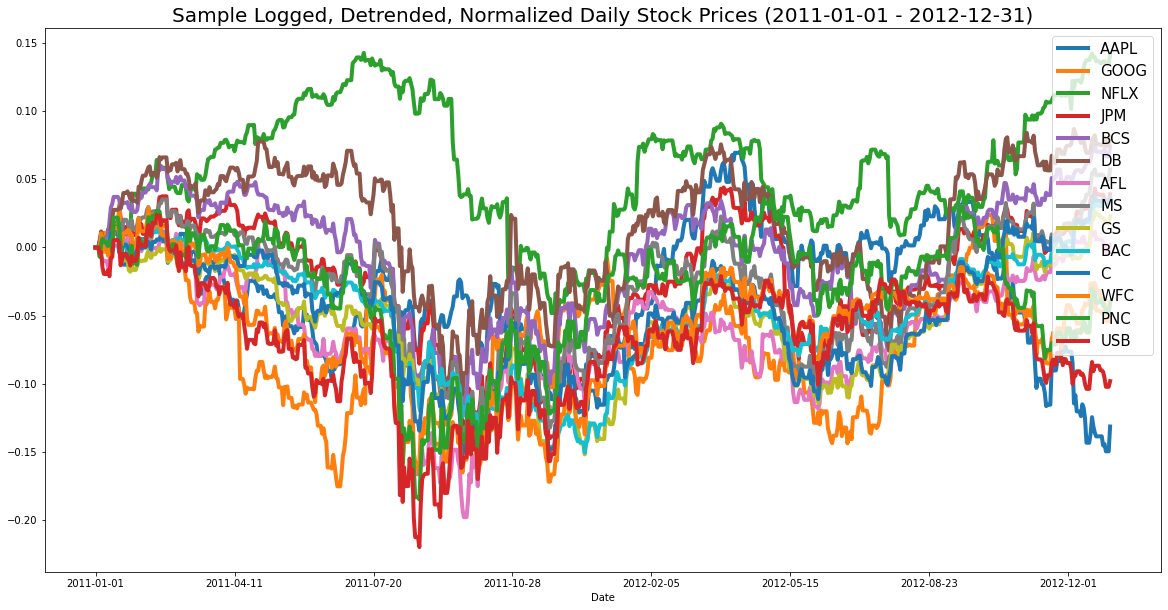

In [115]:
stock_abbrevs=['AAPL','GOOG','NFLX',
               'JPM','BCS','DB','AFL','MS','GS','BAC','C','WFC','PNC','USB']
# stock_abbrevs=['DCT', 'CXM','DUOL', 'BLKB', 'BOX', 'KC', 'ESMT', 'PWSC','TUYA','WEAV' ]
daily_stock_prices_df=FetchPrices(stock_abbrevs,'stock').fetch_daily_prices_df(start_date='2011-01-01',
                                                                               end_date='2012-12-31')

plot_df(daily_stock_prices_df, 
        title ='Sample Logged, Detrended, Normalized Daily Stock Prices ({} - {})'.format(daily_stock_prices_df.index[0], 
                                                                                          daily_stock_prices_df.index[-1]),
        linewidth=4.0)

## Lead-Lag Matrix

We are ready to run Cyclicity Analysis on the daily stock price time-series. We output the heatmap corresponding to the lead-lag matrix of pairwise time-series oriented areas (or precedence strengths).

In [116]:
Daily_CA=CyclicityAnalysis(daily_stock_prices_df)
Daily_CA.plot_lead_lag_df(color_label='Oriented Area')

## Top 10 Leader Follower Pairs

We plot the top $10$ pairs of daily stock prices with highest precedence strengths according to the heatmap, along with their corresponding accumulated daily precedence strength plots throughout the days.

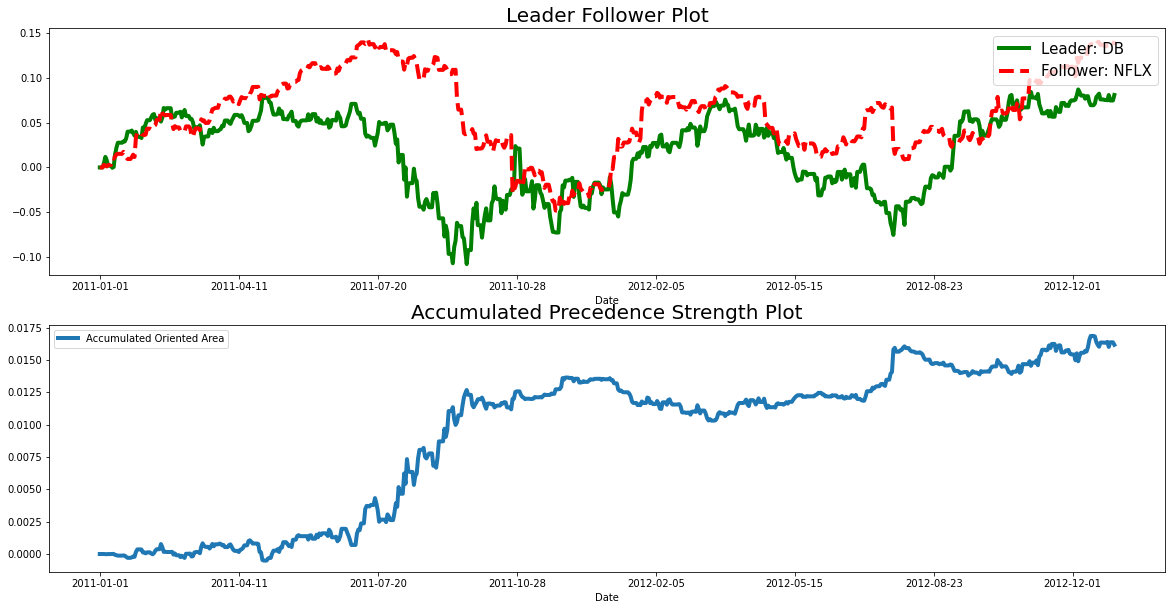

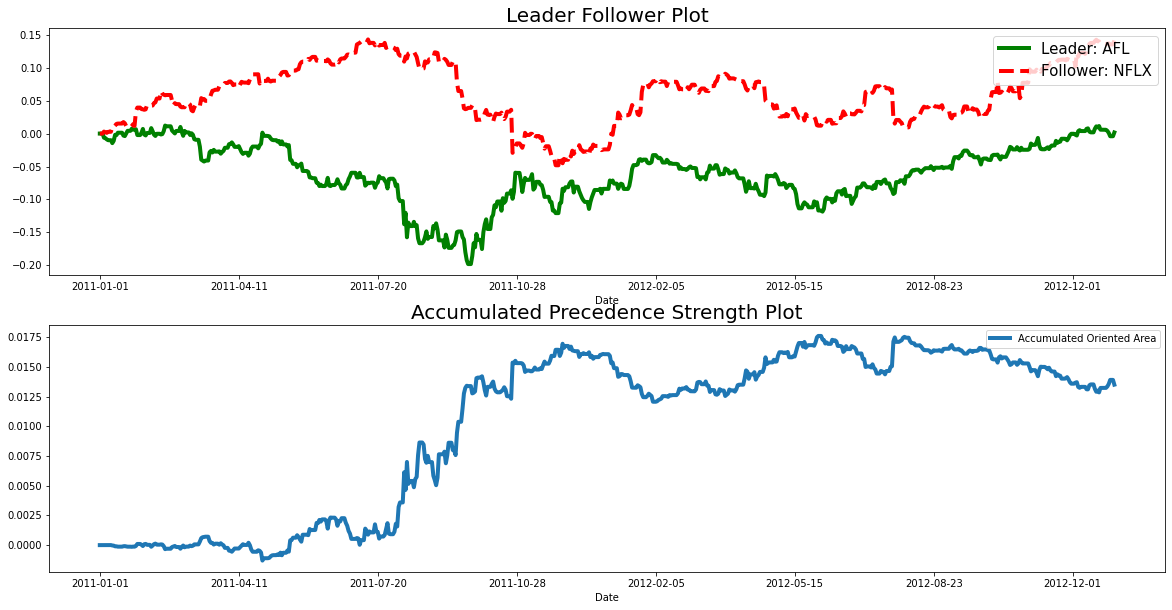

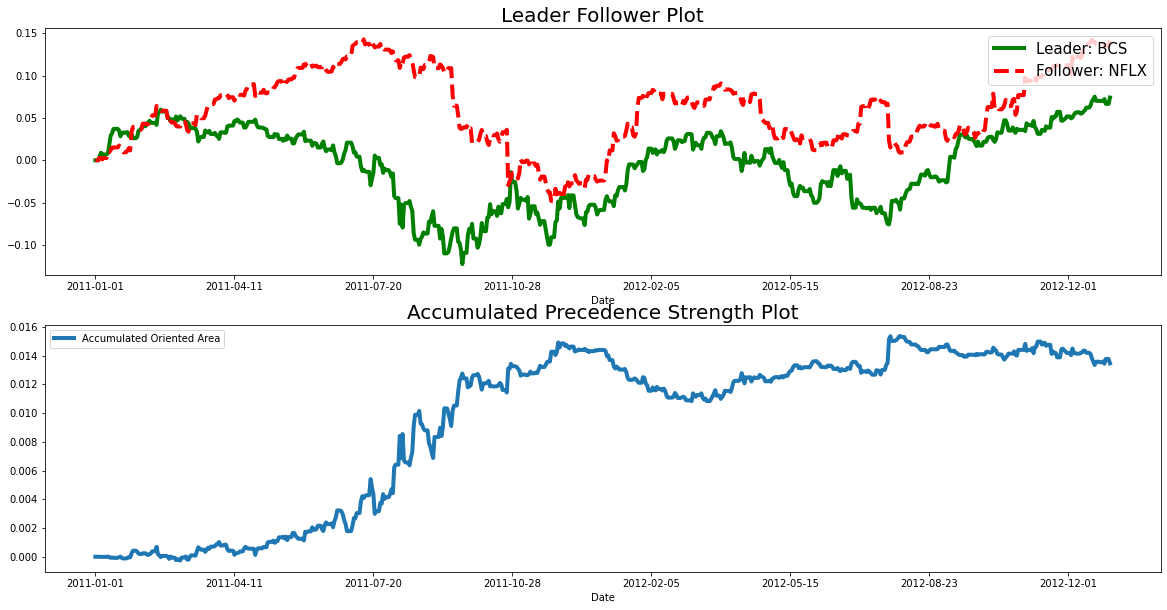

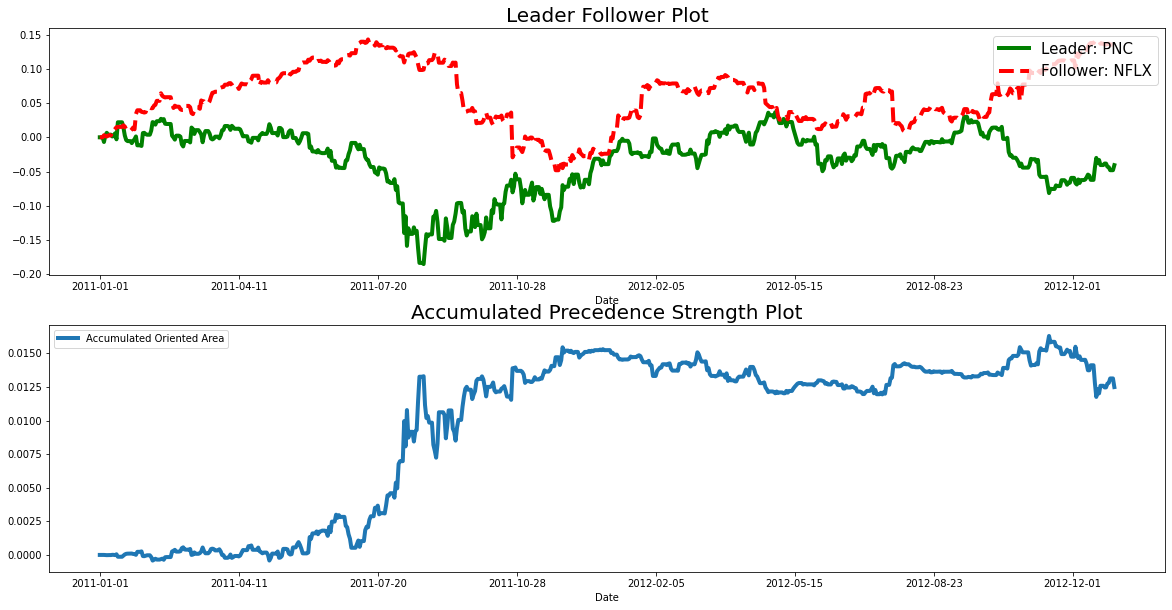

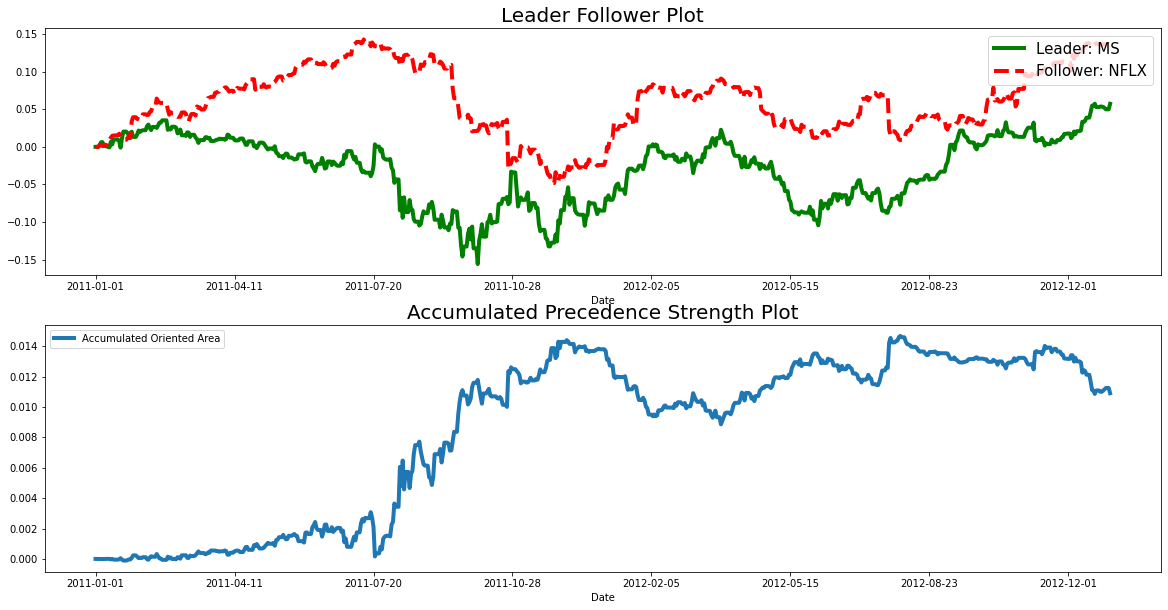

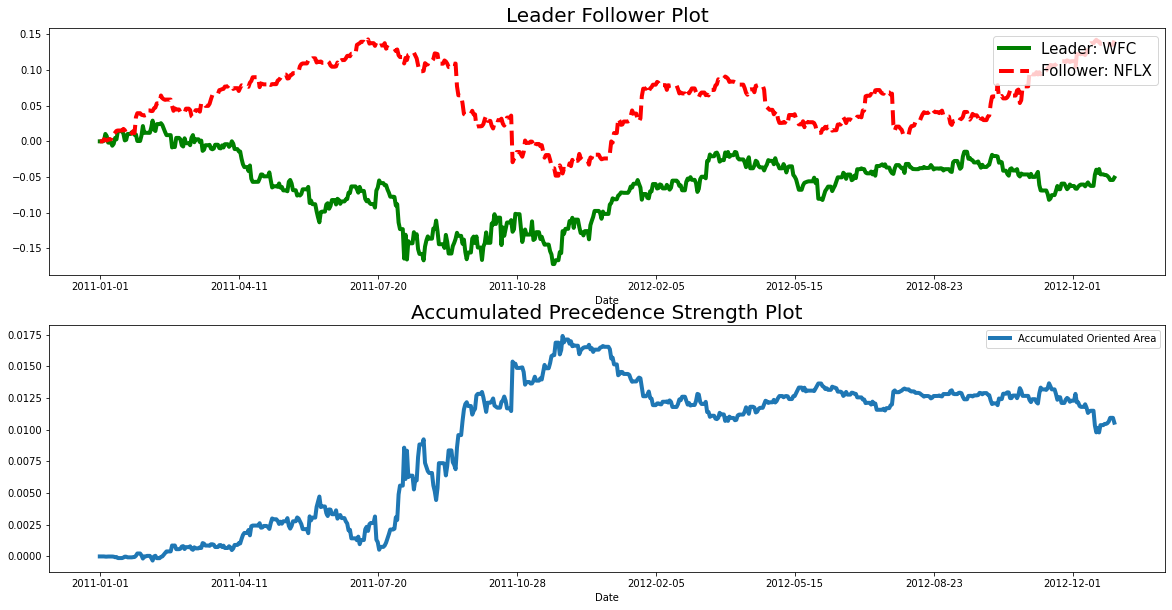

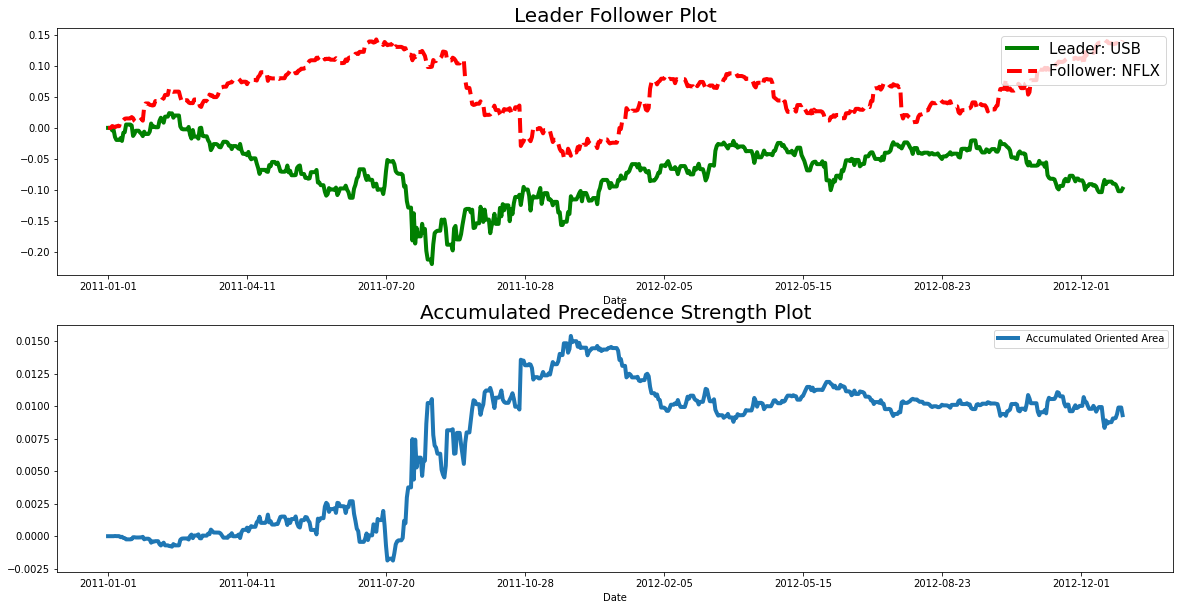

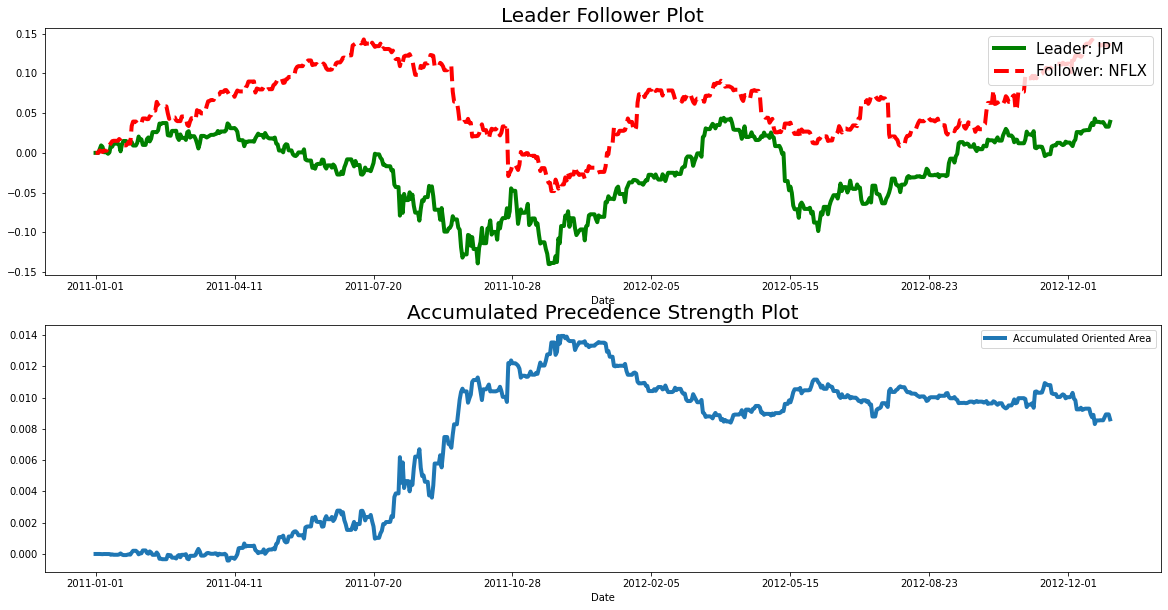

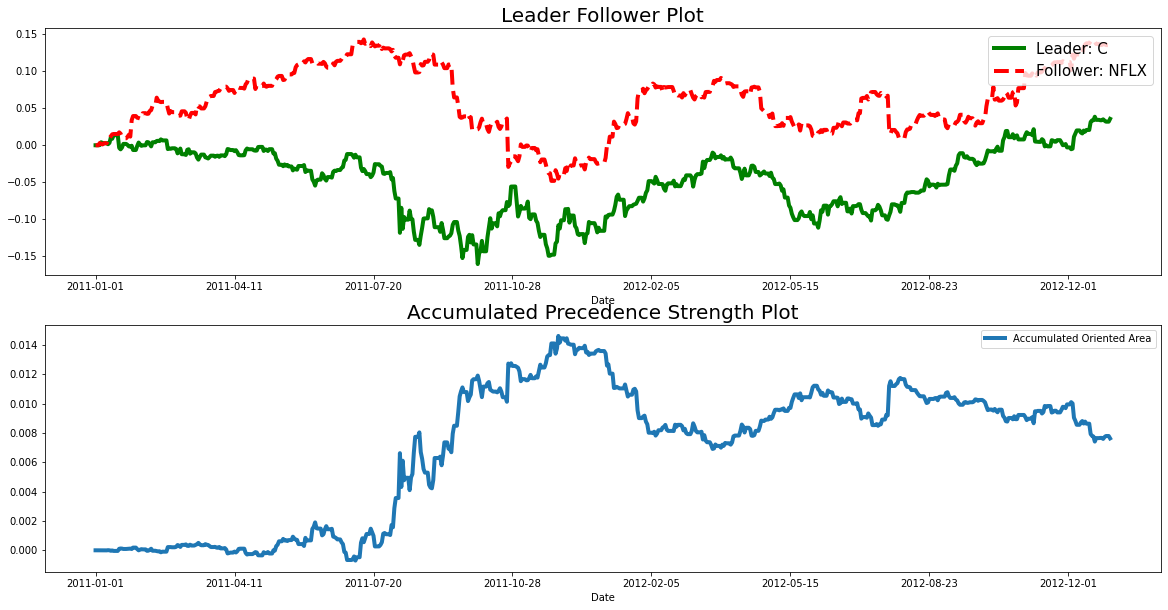

In [118]:
top_pairs = Daily_CA.get_topN_leader_follower_pairs(N=25)
for pair in top_pairs:
    if 'NFLX' == pair[-1]:
        leader, follower = pair
        plot_leader_follower_relationship(daily_stock_prices_df, 
                                          leader,
                                          follower, 
                                          include_accumulated_oriented_area_plot= True)

# Cyclicity Analysis: Intraday Stock Prices

Now, fix a particular trading day. Let $T=\lbrace t_m \rbrace_{m=1}^n$ be the collection of timestamps with $t_1$ being the timestamp corresponding to 9:30 A.M. EST of that trading day and $t_n$ being the timestamp corresponding to 4:00 P.M. EST of that trading day, and each $t_m$ being the timestamp corresponding to $m$ minutes after 9:30 A.M. EST of that trading day (which means $n=391$). 

For each $k \in \lbrace 1, \ \dots \ , N \rbrace,$ let $\left \lbrace x^{(k)}_{t_m} \right \rbrace_{m=1}^n$ be the time-series with $x^{(k)}_{t_m}$ being the stock price of company $k$ at the timestamp $t_m.$ We preprocess each time-series $\left \lbrace x^{(k)}_{t_m} \right \rbrace_{m=1}^n$ by following the procedure for normalization, imputing, and translating.

We implement the data fetching from Polygon.io and preprocessing of intraday stock price time-series. We plot the preprocessed time-series of all companies from the financial sector for today's date. 

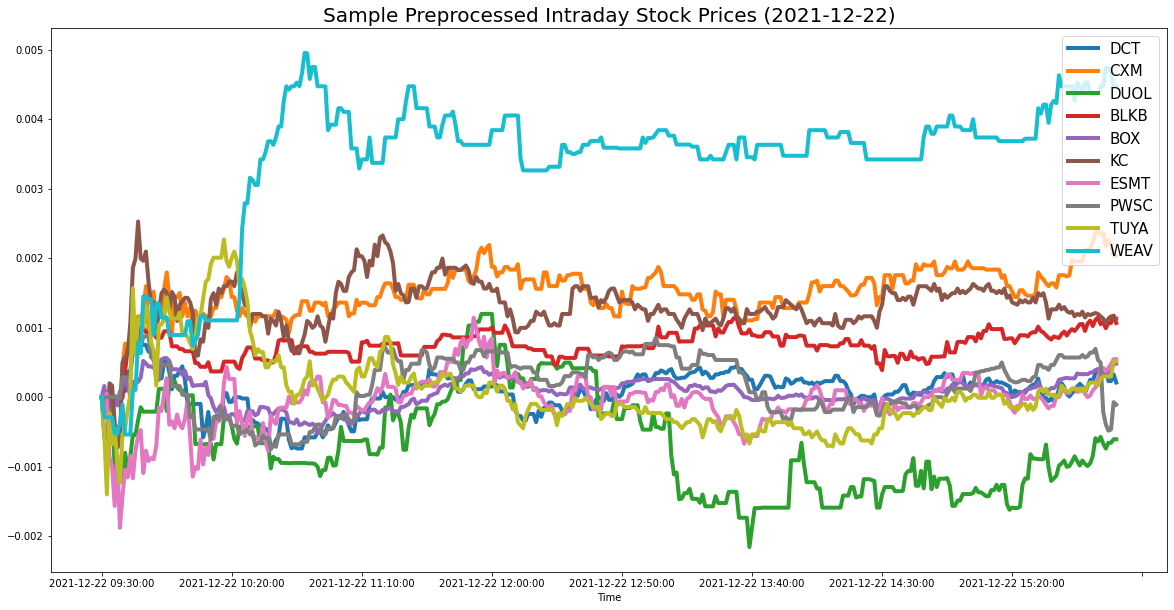

In [76]:
date=today
intraday_stock_prices_df=FetchPrices(stock_abbrevs,'stock').fetch_intraday_prices_df(date)
plot_df(intraday_stock_prices_df, 
        title ='Sample Preprocessed Intraday Stock Prices ({})'.format(date),
        linewidth=4.0)

## Lead Lag Matrix

We run Cyclicity Analysis on the intraday stock price time-series. We output the heatmap of the lead lag matrix.

In [77]:
Intraday_CA=CyclicityAnalysis(intraday_stock_prices_df)
Intraday_CA.plot_lead_lag_df()

## Top 10 Leader Follower Pairs

We obtain the the top $10$ pairs of companies with the highest precedence strengths according to the heatmap. For each pair, we plot the leader follower relationship and their accumulated precedence strength throughout the trading day.

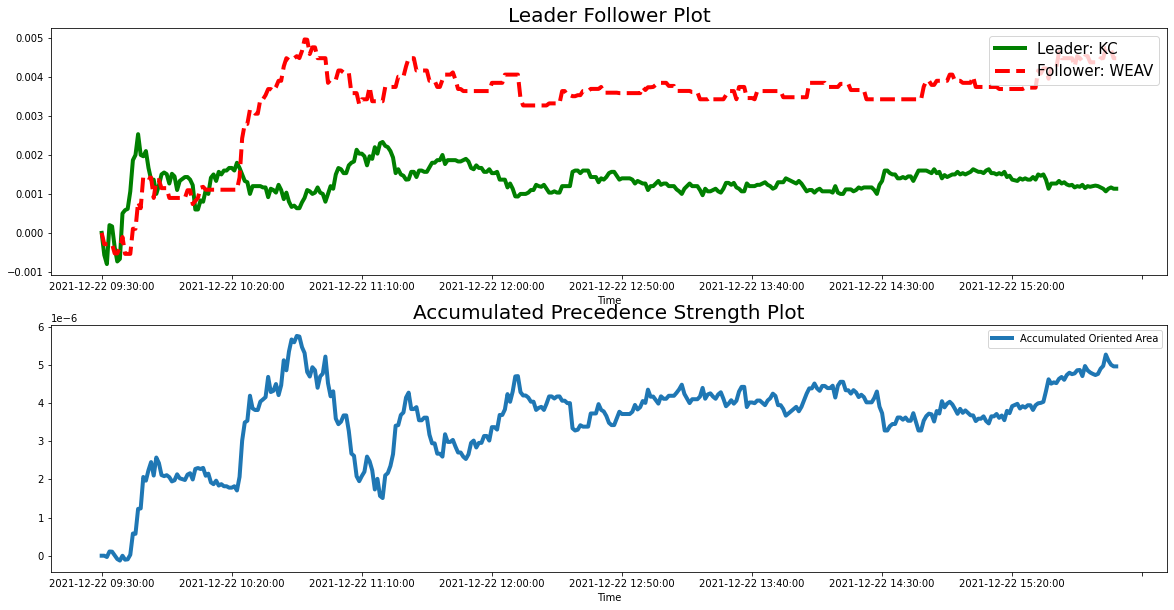

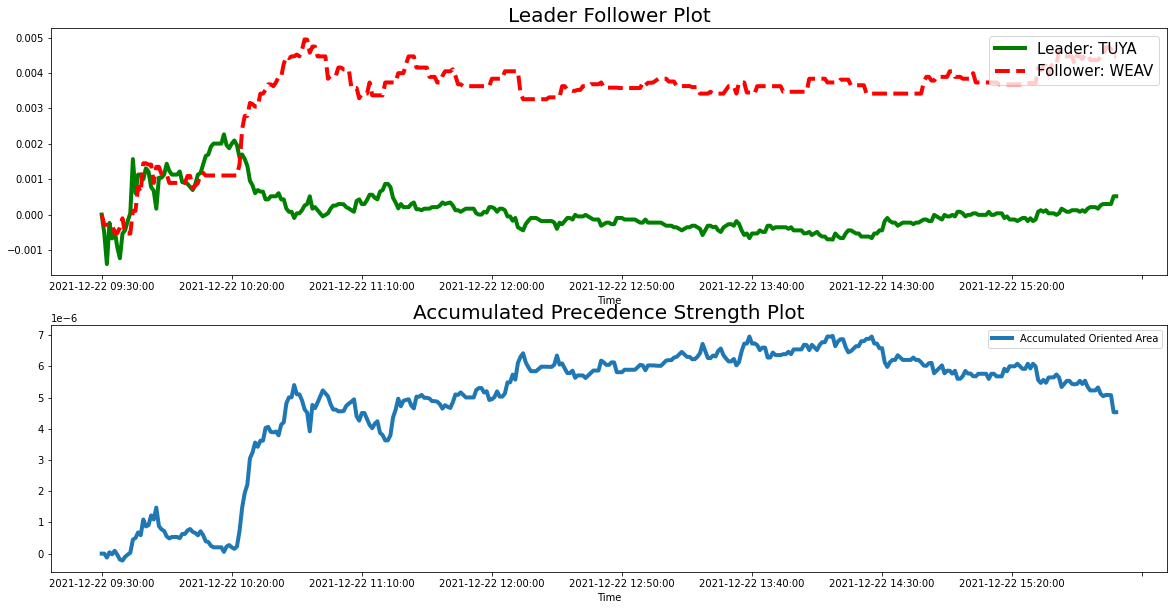

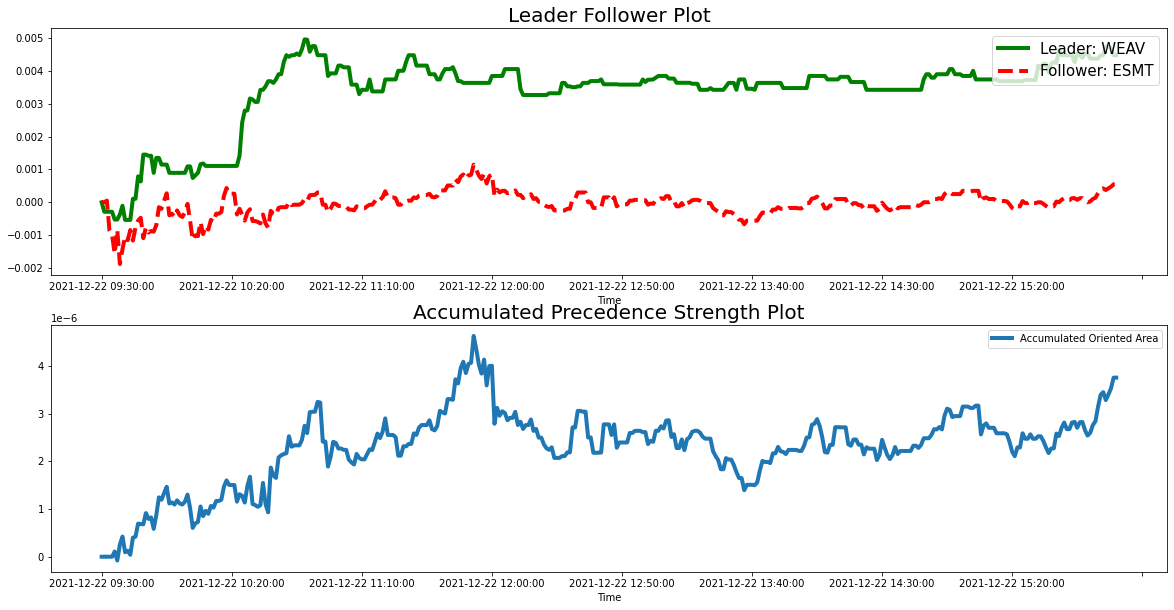

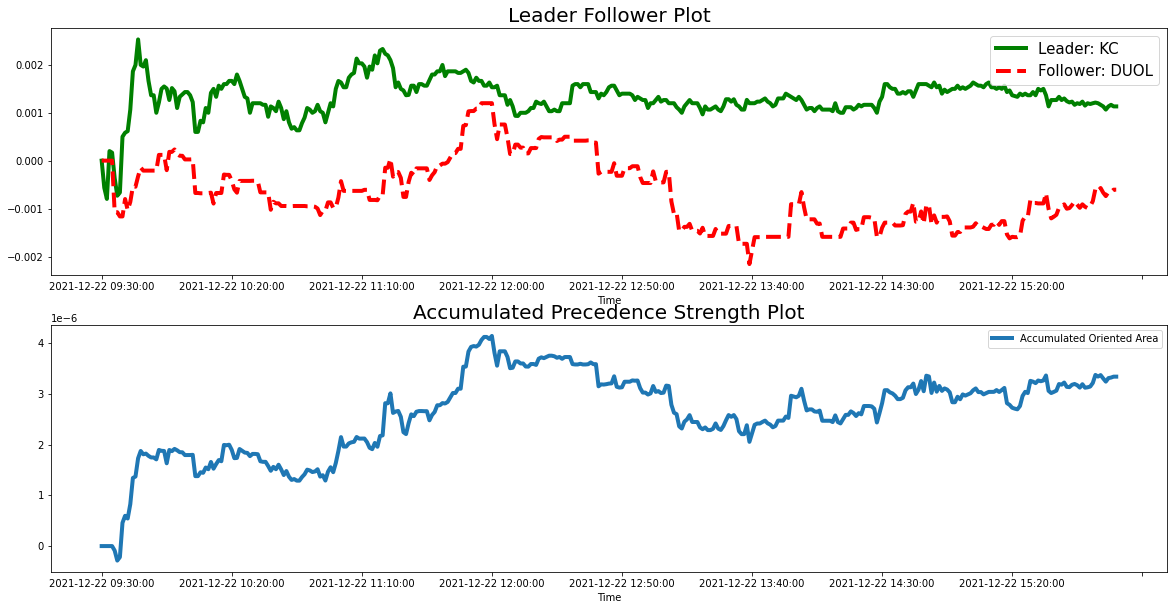

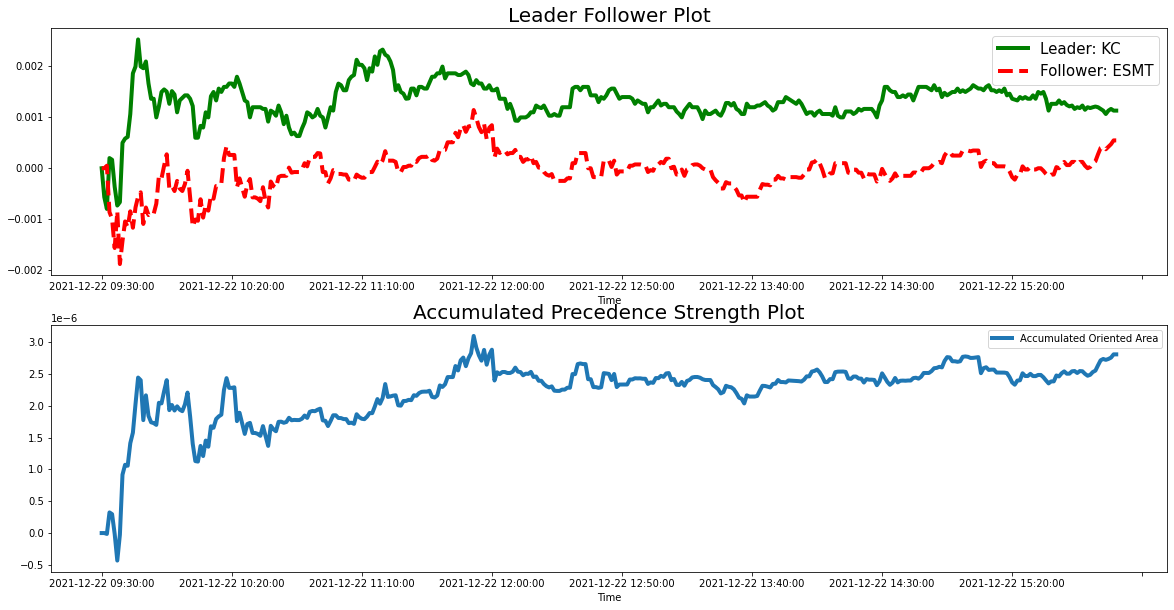

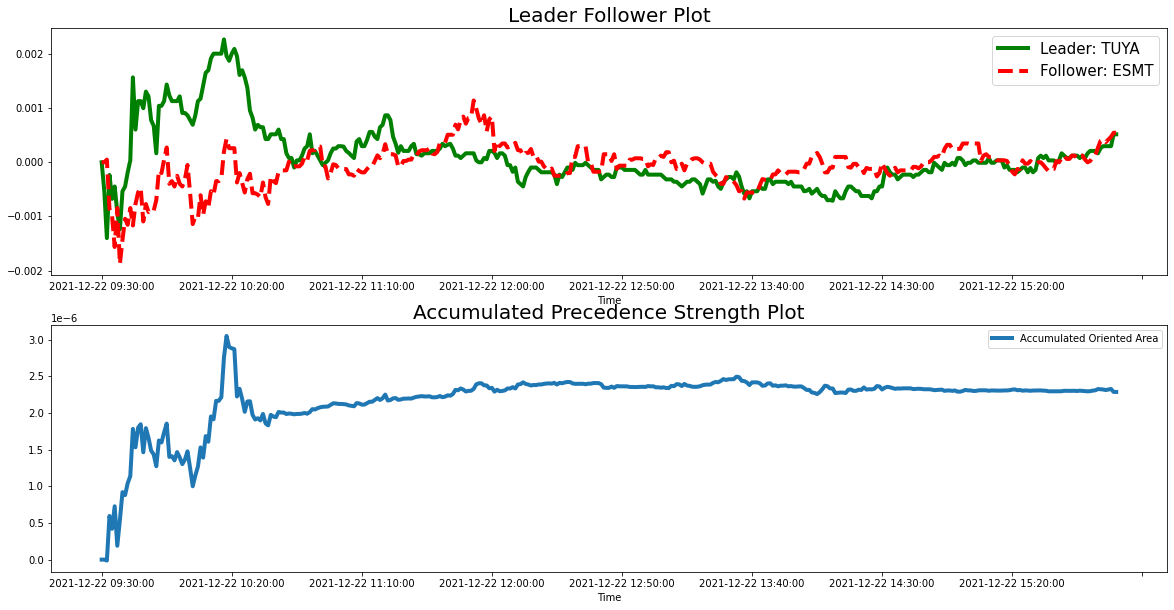

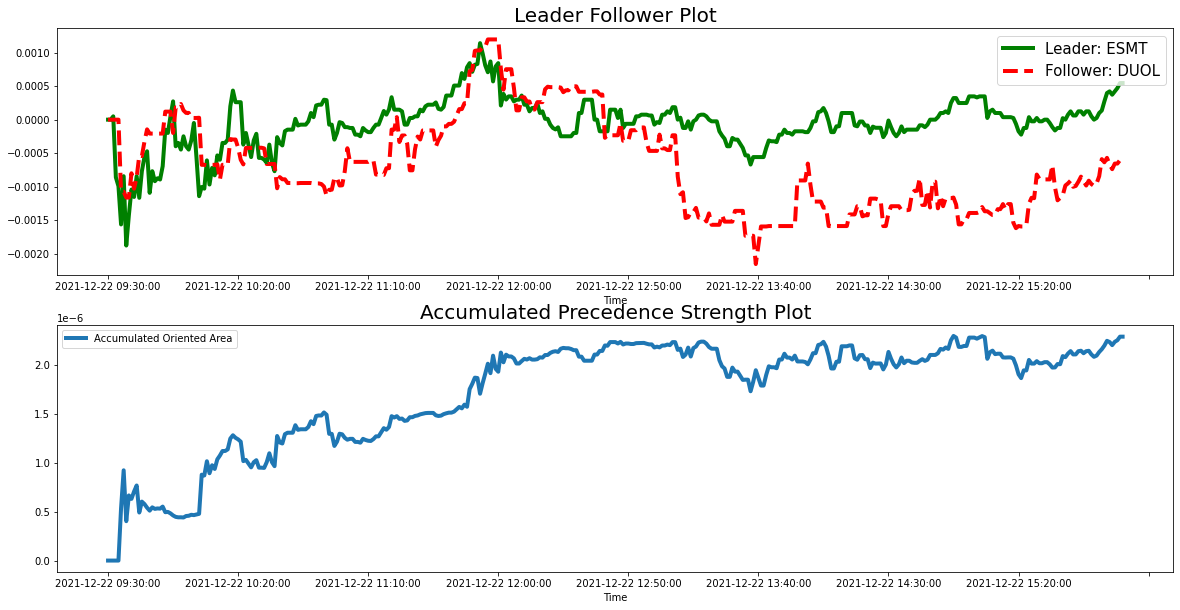

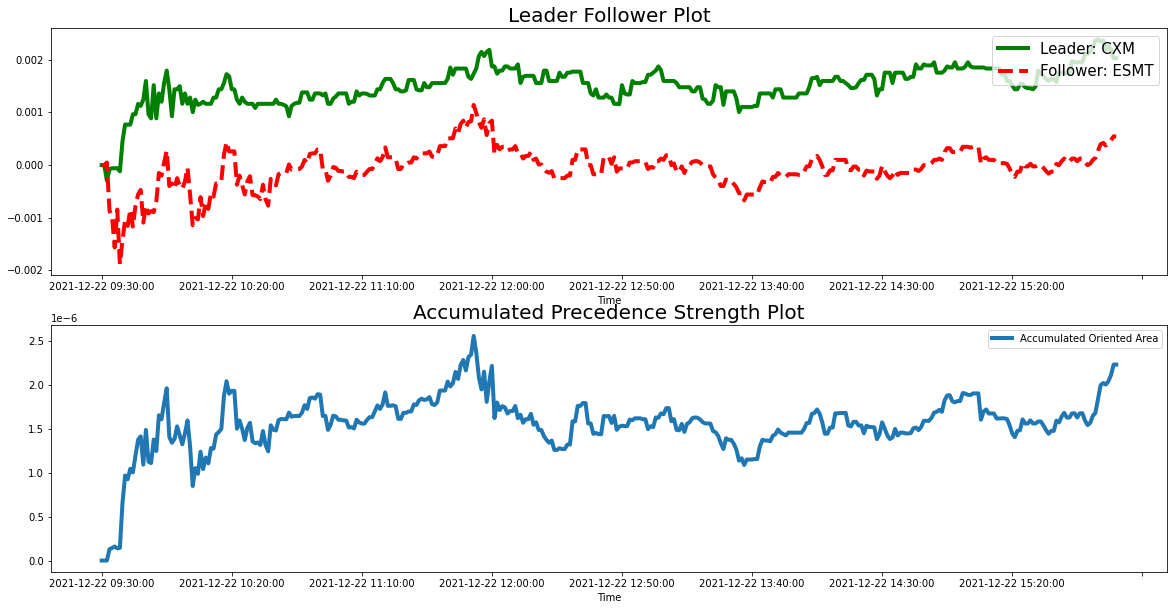

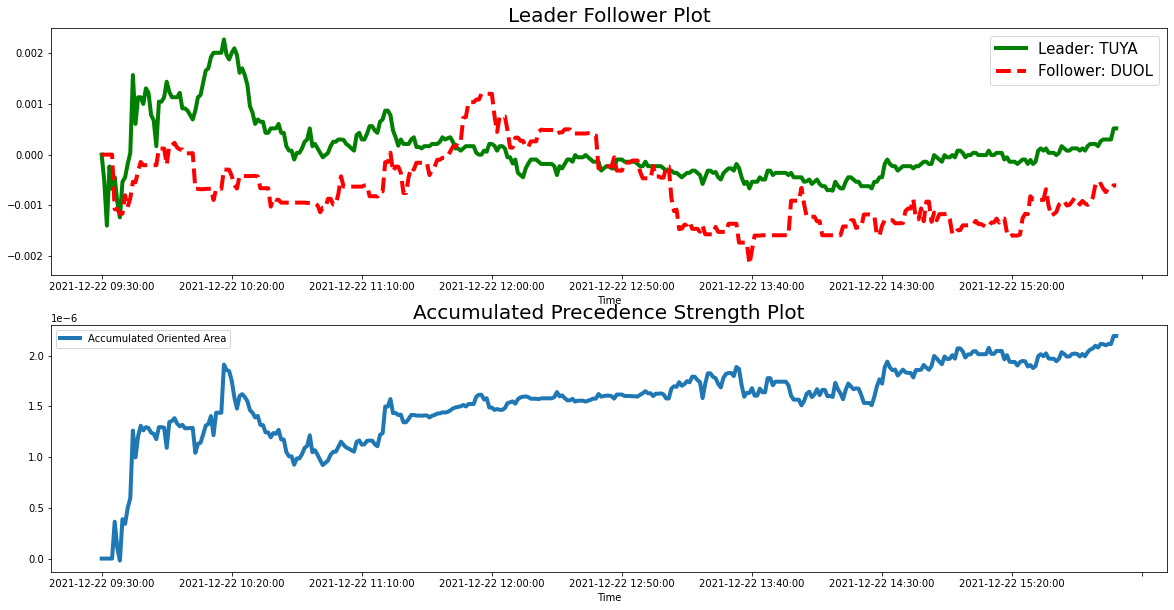

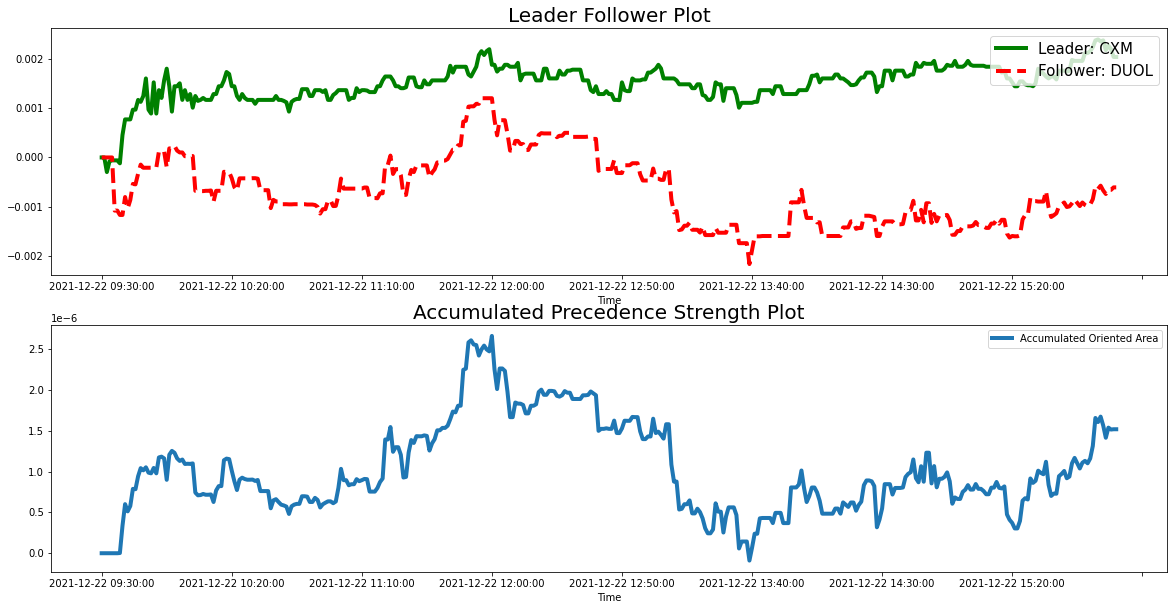

In [78]:
for pair in Intraday_CA.get_topN_leader_follower_pairs():
    leader,follower=pair
    plot_leader_follower_relationship(intraday_stock_prices_df, 
                                      leader, 
                                      follower, 
                                      figsize=(20,10))

## Obtaining Top 10 Strong Leader Follower Company Pairs Per Trading Day

For each 2021 trading day, we run Cyclicity Analysis for the $N$ corresponding stock price time-series and obtain the top $10$ leader follower company pairs for that day. We implement this in the code cell below.

In [47]:
start_date, end_date ='2021-11-01', today
LFA=LeaderFollowerFrequencyAnalysis(stock_abbrevs,'stock',start_date,end_date)
LFA.get_topN_intraday_leader_follower_df(end_date)

SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-01 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-02 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-03 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-04 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-05 ...
FAILED OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-06 ...
FAILED OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-07 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-08 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-09 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-10 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-11 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-12 ...
FAILED OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-13 ...
FAILED OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-11-14 ...
SUCCESS OBTAINING TOP 10

Leader Follower
Date                      
2021-12-22   GOOG     AAPL
2021-12-22   NFLX     AAPL
2021-12-22     MS     GOOG
2021-12-22     MS      EVR
2021-12-22     FB     GOOG
2021-12-22     MS     AAPL
2021-12-22   AMZN     AAPL
2021-12-22    BAC      EVR
2021-12-22     DB     AAPL
2021-12-22     FB     AMZN

## Obtaining 2021 Trading Days Of Strong Leader Follower Relationships

For the $j$-th and $k$-th companies, we obtain the list of all $2021$ trading days for which their leader follower relationship was strong. These are the days in which the oriented area for their respective intraday time-series was amongst the top $10.$ We implement this in the code cell below.

In [48]:
LFA.strong_leader_follower_relationship_days_df

Leader Follower  Number of Strong Leader Follower Dates  \
0       GS      EVR                                       7   
1       MS      EVR                                       7   
2       FB      EVR                                       7   
3       FB     AMZN                                       6   
4      WFC      EVR                                       6   
..     ...      ...                                     ...   
157    EVR       FB                                       1   
158    EVR      BCS                                       1   
159     DB     GOOG                                       1   
160     DB       FB                                       1   
161    WFC     NFLX                                       1   

                          Strong Leader Follower Dates  
0    [2021-11-17, 2021-11-18, 2021-11-30, 2021-12-0...  
1    [2021-11-17, 2021-11-24, 2021-11-30, 2021-12-0...  
2    [2021-11-11, 2021-11-17, 2021-11-30, 2021-12-0...  
3    [2021-11-12, 2021-11-17, 2021-12-06, 2021-12-1...  
4    [2021-11-03, 2021-11-04, 2021-11-11, 2021-11-1...  
..                                                 ...  
157                                       [2021-11-15]  
158                                       [2021-11-29]  
159                                       [2021-12-06]  
160                                       [2021-11-15]  
161                                       [2021-11-04]  

[162 rows x 4 columns]

## Strong Frequency Count Matrix of 2021 Trading Days with Strong Leader Follower Relationships

For the $j$-th and $k$-th companies, we obtain $C_{j,k},$ which is the number of $2021$ trading days for which their leader follower relationship was strong. We construct the $N \times N$ matrix $C,$ whose $(j,k)$-th entry is $C_{j,k}.$ We call this the $\textbf{strong frequency count matrix.}$ 

In [49]:
LFA.plot_strong_frequency_count_df()

## S&P 500 Sector Intraday Analysis

For each S&P 500 sector, we obtain the available companies and obtain the corresponding frequency count matrix for $2021.$

In [50]:
def SP_500_leader_follower_intraday_analysis(sector_name, start_date = '2021-01-01', end_date = today):
    stock_abbrevs = get_SP_500_sector_stock_abbrevs(sector_name)
    save_directory='S&P_500_{}_Top_Intraday_Leader_Followers'.format(sector_name)
    LFA=LeaderFollowerFrequencyAnalysis(stock_abbrevs,'stock',start_date,end_date,save_directory)
    
    if end_date == today:
        LFA.get_topN_intraday_leader_follower_df(date=end_date,update=True)
        
    LFA.plot_strong_frequency_count_df(title=sector_name)
    return LFA.strong_leader_follower_relationship_days_df


for sector_name in SP_500_sector_names:
    print("FETCHING {} Strong Frequency Count Matrix ...".format(sector_name))
    start_date, end_date ='2021-01-01', today
    strong_leader_follower_relationship_days_df=SP_500_leader_follower_intraday_analysis(sector_name, start_date,end_date)
    print(strong_leader_follower_relationship_days_df.head(5))

FETCHING Consumer Discretionary Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0   ETSY     PENN                                      16   
1   NCLH     TSLA                                      15   
2   ETSY      GPS                                      14   
3   NCLH     ETSY                                      13   
4   PENN     TSLA                                      12   

                        Strong Leader Follower Dates  
0  [2021-01-11, 2021-01-12, 2021-01-15, 2021-01-1...  
1  [2021-01-07, 2021-01-29, 2021-02-24, 2021-03-2...  
2  [2021-01-12, 2021-02-26, 2021-04-26, 2021-05-0...  
3  [2021-02-05, 2021-02-24, 2021-02-25, 2021-03-0...  
4  [2021-01-04, 2021-01-07, 2021-01-08, 2021-04-3...  
FETCHING Financials Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0   SIVB     MKTX                                      23   
1   MKTX     SIVB                                      21   
2   CBOE     MKTX                                      18   
3   MSCI     SIVB                                      15   
4    LNC     SIVB                                      15   

                        Strong Leader Follower Dates  
0  [2021-03-01, 2021-04-06, 2021-04-09, 2021-04-2...  
1  [2021-01-12, 2021-01-15, 2021-02-23, 2021-03-0...  
2  [2021-02-08, 2021-02-19, 2021-03-05, 2021-03-1...  
3  [2021-01-29, 2021-03-12, 2021-03-31, 2021-04-2...  
4  [2021-01-11, 2021-01-29, 2021-03-11, 2021-03-1...  
FETCHING Energy Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    OXY     FANG                                      32   
1    APA     FANG                                      29   
2   FANG      APA                                      23   
3    BKR     FANG                                      23   
4    DVN      BKR                                      22   

                        Strong Leader Follower Dates  
0  [2021-01-12, 2021-02-03, 2021-02-08, 2021-03-0...  
1  [2021-02-03, 2021-02-10, 2021-03-01, 2021-03-0...  
2  [2021-01-06, 2021-02-16, 2021-02-18, 2021-02-2...  
3  [2021-03-08, 2021-03-11, 2021-03-17, 2021-03-1...  
4  [2021-02-10, 2021-02-22, 2021-03-05, 2021-03-2...  
FETCHING Information Technology Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0   ENPH     MPWR                                      19   
1   ENPH     IPGP                                      19   
2   ENPH     PAYC                                      17   
3    DXC     ENPH                                      16   
4   ENPH     ANSS                                      14   

                        Strong Leader Follower Dates  
0  [2021-02-03, 2021-02-16, 2021-02-24, 2021-03-1...  
1  [2021-01-05, 2021-01-06, 2021-02-03, 2021-02-1...  
2  [2021-01-15, 2021-01-26, 2021-02-26, 2021-03-1...  
3  [2021-01-07, 2021-01-08, 2021-01-21, 2021-02-0...  
4  [2021-03-15, 2021-03-18, 2021-04-01, 2021-04-0...  
FETCHING Health Care Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    MTD     MRNA                                      30   
1   TECH     MRNA                                      30   
2   MRNA      MTD                                      28   
3   MRNA      BIO                                      27   
4   MRNA     TECH                                      25   

                        Strong Leader Follower Dates  
0  [2021-01-26, 2021-01-27, 2021-03-02, 2021-03-1...  
1  [2021-01-26, 2021-01-27, 2021-02-01, 2021-03-0...  
2  [2021-01-08, 2021-01-12, 2021-01-15, 2021-03-0...  
3  [2021-01-07, 2021-01-15, 2021-02-18, 2021-02-2...  
4  [2021-01-08, 2021-02-26, 2021-03-03, 2021-03-0...  
FETCHING Materials Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    FCX      ALB                                      31   
1    ALB      NUE                                      26   
2    NUE      FCX                                      25   
3    NUE      MOS                                      25   
4     CF      ALB                                      25   

                        Strong Leader Follower Dates  
0  [2021-01-04, 2021-01-15, 2021-01-19, 2021-02-1...  
1  [2021-02-03, 2021-03-03, 2021-03-10, 2021-04-2...  
2  [2021-01-15, 2021-03-09, 2021-03-17, 2021-03-2...  
3  [2021-01-07, 2021-01-12, 2021-02-19, 2021-03-0...  
4  [2021-02-16, 2021-02-18, 2021-02-25, 2021-03-1...  
FETCHING Consumer Staples Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0     KR      WBA                                      20   
1     KR      TAP                                      20   
2    WBA       LW                                      19   
3    WBA      TAP                                      17   
4     LW       KR                                      17   

                        Strong Leader Follower Dates  
0  [2021-01-26, 2021-02-01, 2021-03-15, 2021-03-2...  
1  [2021-01-12, 2021-01-26, 2021-01-27, 2021-02-0...  
2  [2021-01-04, 2021-01-07, 2021-01-08, 2021-01-1...  
3  [2021-01-19, 2021-01-20, 2021-01-27, 2021-03-1...  
4  [2021-01-14, 2021-01-29, 2021-02-05, 2021-02-2...  
FETCHING Communication Services Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0   TWTR    DISCA                                      24   
1   VIAC      LYV                                      23   
2   TWTR     VIAC                                      23   
3   MTCH     VIAC                                      22   
4   VIAC     TWTR                                      21   

                        Strong Leader Follower Dates  
0  [2021-01-29, 2021-02-22, 2021-02-23, 2021-03-1...  
1  [2021-01-12, 2021-01-20, 2021-01-21, 2021-02-1...  
2  [2021-01-06, 2021-01-25, 2021-01-26, 2021-02-0...  
3  [2021-01-13, 2021-01-15, 2021-01-25, 2021-01-2...  
4  [2021-01-11, 2021-02-02, 2021-02-05, 2021-02-1...  
FETCHING Real Estate Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0   EQIX      HST                                      19   
1    HST     CBRE                                      18   
2    SPG      HST                                      17   
3    HST      VNO                                      16   
4    VNO      HST                                      15   

                        Strong Leader Follower Dates  
0  [2021-01-11, 2021-01-21, 2021-03-02, 2021-03-0...  
1  [2021-01-04, 2021-01-05, 2021-01-12, 2021-01-2...  
2  [2021-01-26, 2021-03-25, 2021-03-29, 2021-04-0...  
3  [2021-01-29, 2021-02-19, 2021-02-22, 2021-03-2...  
4  [2021-02-18, 2021-03-25, 2021-04-22, 2021-05-0...  
FETCHING Industrials Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    AAL     GNRC                                      21   
1    UAL     GNRC                                      16   
2   GNRC      TDG                                      15   
3    AAL      TDG                                      13   
4    AAL      URI                                      13   

                        Strong Leader Follower Dates  
0  [2021-01-19, 2021-03-01, 2021-03-10, 2021-03-1...  
1  [2021-01-25, 2021-02-19, 2021-03-01, 2021-03-1...  
2  [2021-03-03, 2021-03-18, 2021-04-14, 2021-05-1...  
3  [2021-03-04, 2021-03-12, 2021-03-24, 2021-04-2...  
4  [2021-03-04, 2021-03-29, 2021-04-22, 2021-07-0...  
FETCHING Utilities Strong Frequency Count Matrix ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-22 ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    NRG      AES                                      26   
1    NRG      WEC                                      25   
2    AES      NRG                                      23   
3    NRG      PNW                                      22   
4    NRG      SRE                                      22   

                        Strong Leader Follower Dates  
0  [2021-01-08, 2021-02-10, 2021-02-23, 2021-03-1...  
1  [2021-01-05, 2021-01-08, 2021-02-16, 2021-03-0...  
2  [2021-01-25, 2021-02-01, 2021-02-18, 2021-02-1...  
3  [2021-01-05, 2021-01-08, 2021-03-01, 2021-03-0...  
4  [2021-01-05, 2021-01-12, 2021-01-25, 2021-03-0...  


# Cyclicity Analysis: Intraday Cryptocurrency Prices

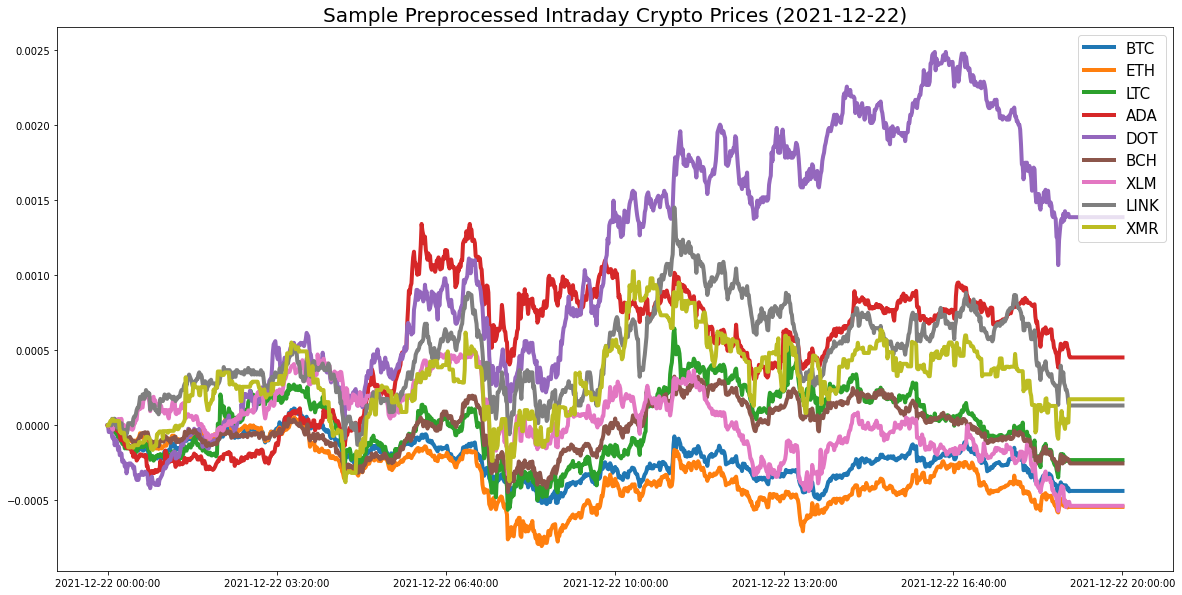

In [62]:
crypto_abbrevs=['BTC','ETH','LTC','ADA','DOT','BCH','XLM','LINK','BNB','XMR']
start_date, end_date ='2021-11-01', today
date=today
intraday_crypto_prices_df=FetchPrices(crypto_abbrevs,'crypto').fetch_intraday_prices_df(date)
plot_df(intraday_crypto_prices_df, 
        title ='Sample Preprocessed Intraday Crypto Prices ({})'.format(date),
        linewidth=4.0)

In [ ]:
Crypto_CA=CyclicityAnalysis(intraday_crypto_prices_df)
Crypto_CA.plot_lead_lag_df()

In [ ]:
Crypto_CA.plot_eigenvalue_moduli_and_sorted_dominant_eigenvector_components()

In [ ]:
for pair in Crypto_CA.get_topN_leader_follower_pairs():
    leader,follower=pair
    plot_leader_follower_relationship(intraday_crypto_prices_df, 
                                      leader, 
                                      follower, 
                                      figsize=(20,10),
                                      include_accumulated_oriented_area_plot=True)

In [ ]:
def crypto_follower_intraday_analysis(crypto_abbrevs, start_date = '2021-01-01', end_date = today):
    save_directory='Crypto_Top_Intraday_Leader_Followers'
    
    LFA=LeaderFollowerFrequencyAnalysis(crypto_abbrevs,'crypto',start_date,end_date,save_directory)
    
    if end_date == today:
        LFA.get_topN_intraday_leader_follower_df(date=end_date,update=True)
        
    LFA.plot_strong_frequency_count_df(title='Crypto Frequency Matrix')
    return LFA.strong_leader_follower_relationship_days_df

# !rm -r Crypto_Top_Intraday_Leader_Followers
start_date, end_date ='2021-01-01', today
strong_leader_follower_relationship_days_df=crypto_follower_intraday_analysis(crypto_abbrevs, start_date, end_date)

In [ ]:
index=1
leader,follower,strong_dates = strong_leader_follower_relationship_days_df.iloc[index]['Leader'],\
strong_leader_follower_relationship_days_df.iloc[index]['Follower'],\
strong_leader_follower_relationship_days_df.iloc[index]['Strong Leader Follower Dates']
for date in strong_dates[:10]:
    df=FetchPrices([leader,follower],'crypto').fetch_intraday_prices_df(date)
    plot_leader_follower_relationship(df,leader,follower,include_accumulated_oriented_area_plot=False,figsize=(20,5))

# Cyclicity Analysis: Daily Aggregated S&P 500 Prices

In [ ]:
import investpy
indices_dicts=investpy.indices.get_indices_dict(country='United States')
SP_500_indices=[d['full_name'] for d in indices_dicts if 'S&P 500' in d['full_name'] and d['class']=='primary_sectors']
SP_500_indices

In [ ]:
start_date='2020-01-01'
end_date='2020-12-31'
daily_SP_500_indices_dfs= Parallel(n_jobs=11,
                             verbose=100,
                             prefer='threads')(delayed(investpy.get_index_historical_data)\
                                               (index,'United States', 
                                                pd.to_datetime(start_date).strftime("%d/%m/%Y"), 
                                                pd.to_datetime(end_date).strftime("%d/%m/%Y"))
                                               for index in SP_500_indices)
daily_SP_500_indices_df=pd.concat([df[['Close']] for df in daily_SP_500_indices_dfs],axis=1)
daily_SP_500_indices_df.columns=[index.replace("S&P 500 ","") for index in SP_500_indices]

for col in daily_SP_500_indices_df.columns:
    logged_col=np.log(daily_SP_500_indices_df[[col]].dropna())
    detrended_logged_col=sc.signal.detrend(logged_col[col])
    norm_col=np.linalg.norm(detrended_logged_col,2)
    daily_SP_500_indices_df[col].loc[logged_col.index]=detrended_logged_col/norm_col

daily_SP_500_indices_df.fillna(method='ffill',inplace=True)
daily_SP_500_indices_df.fillna(method='bfill',inplace=True)
daily_SP_500_indices_df=daily_SP_500_indices_df-daily_SP_500_indices_df.iloc[0]

In [ ]:
plot_df(daily_SP_500_indices_df,title='Daily Aggregated S&P 500 Prices',linewidth=6.0,figsize=(12,5))

In [ ]:
Indices_CA=CyclicityAnalysis(daily_SP_500_indices_df)

In [ ]:
Indices_CA.plot_lead_lag_df(color_label='Precedence Strength')

In [ ]:
Indices_CA.plot_eigenvalue_moduli_and_sorted_dominant_eigenvector_components()

In [ ]:
top_pairs=Indices_CA.get_topN_leader_follower_pairs()

In [ ]:
for pair in top_pairs:
    leader,follower=pair
    plot_leader_follower_relationship(daily_SP_500_indices_df, 
                                      leader, 
                                      follower, 
                                      figsize=(10,5), 
                                      include_accumulated_oriented_area_plot=False)